Using terrain: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif
Using CSV: /Users/wangbobo/Desktop/2nd_Assignment-20251222/uk现有风电场选址.csv
Wind total: 2747 | Onshore: 2653 | Offshore: 94
After extent clip | Onshore: 2653 | Offshore: 84


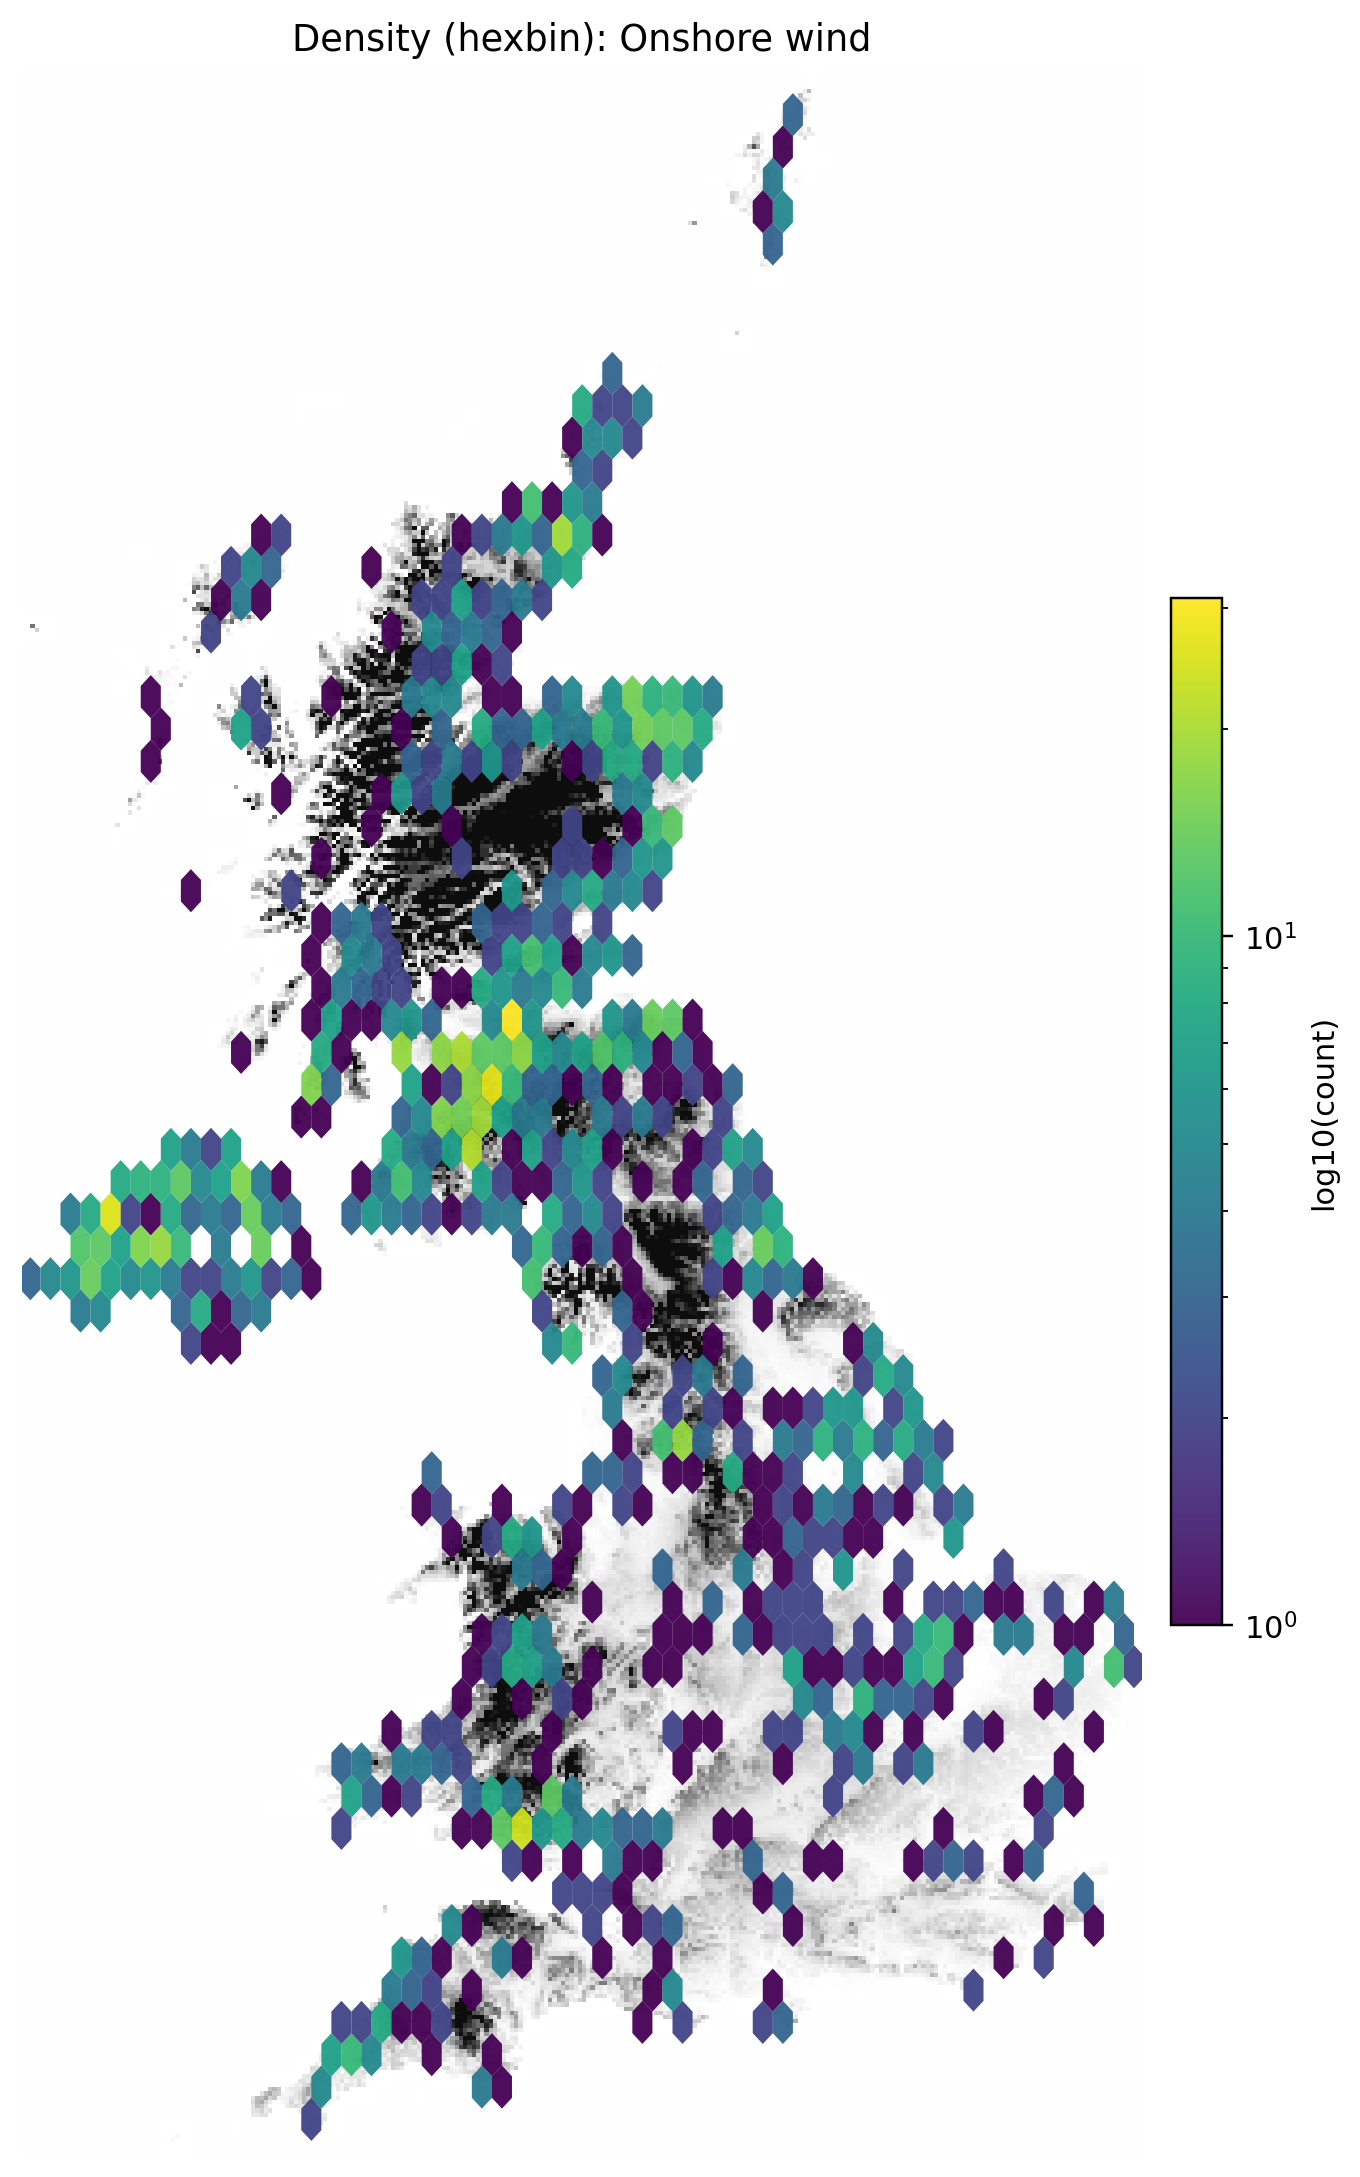

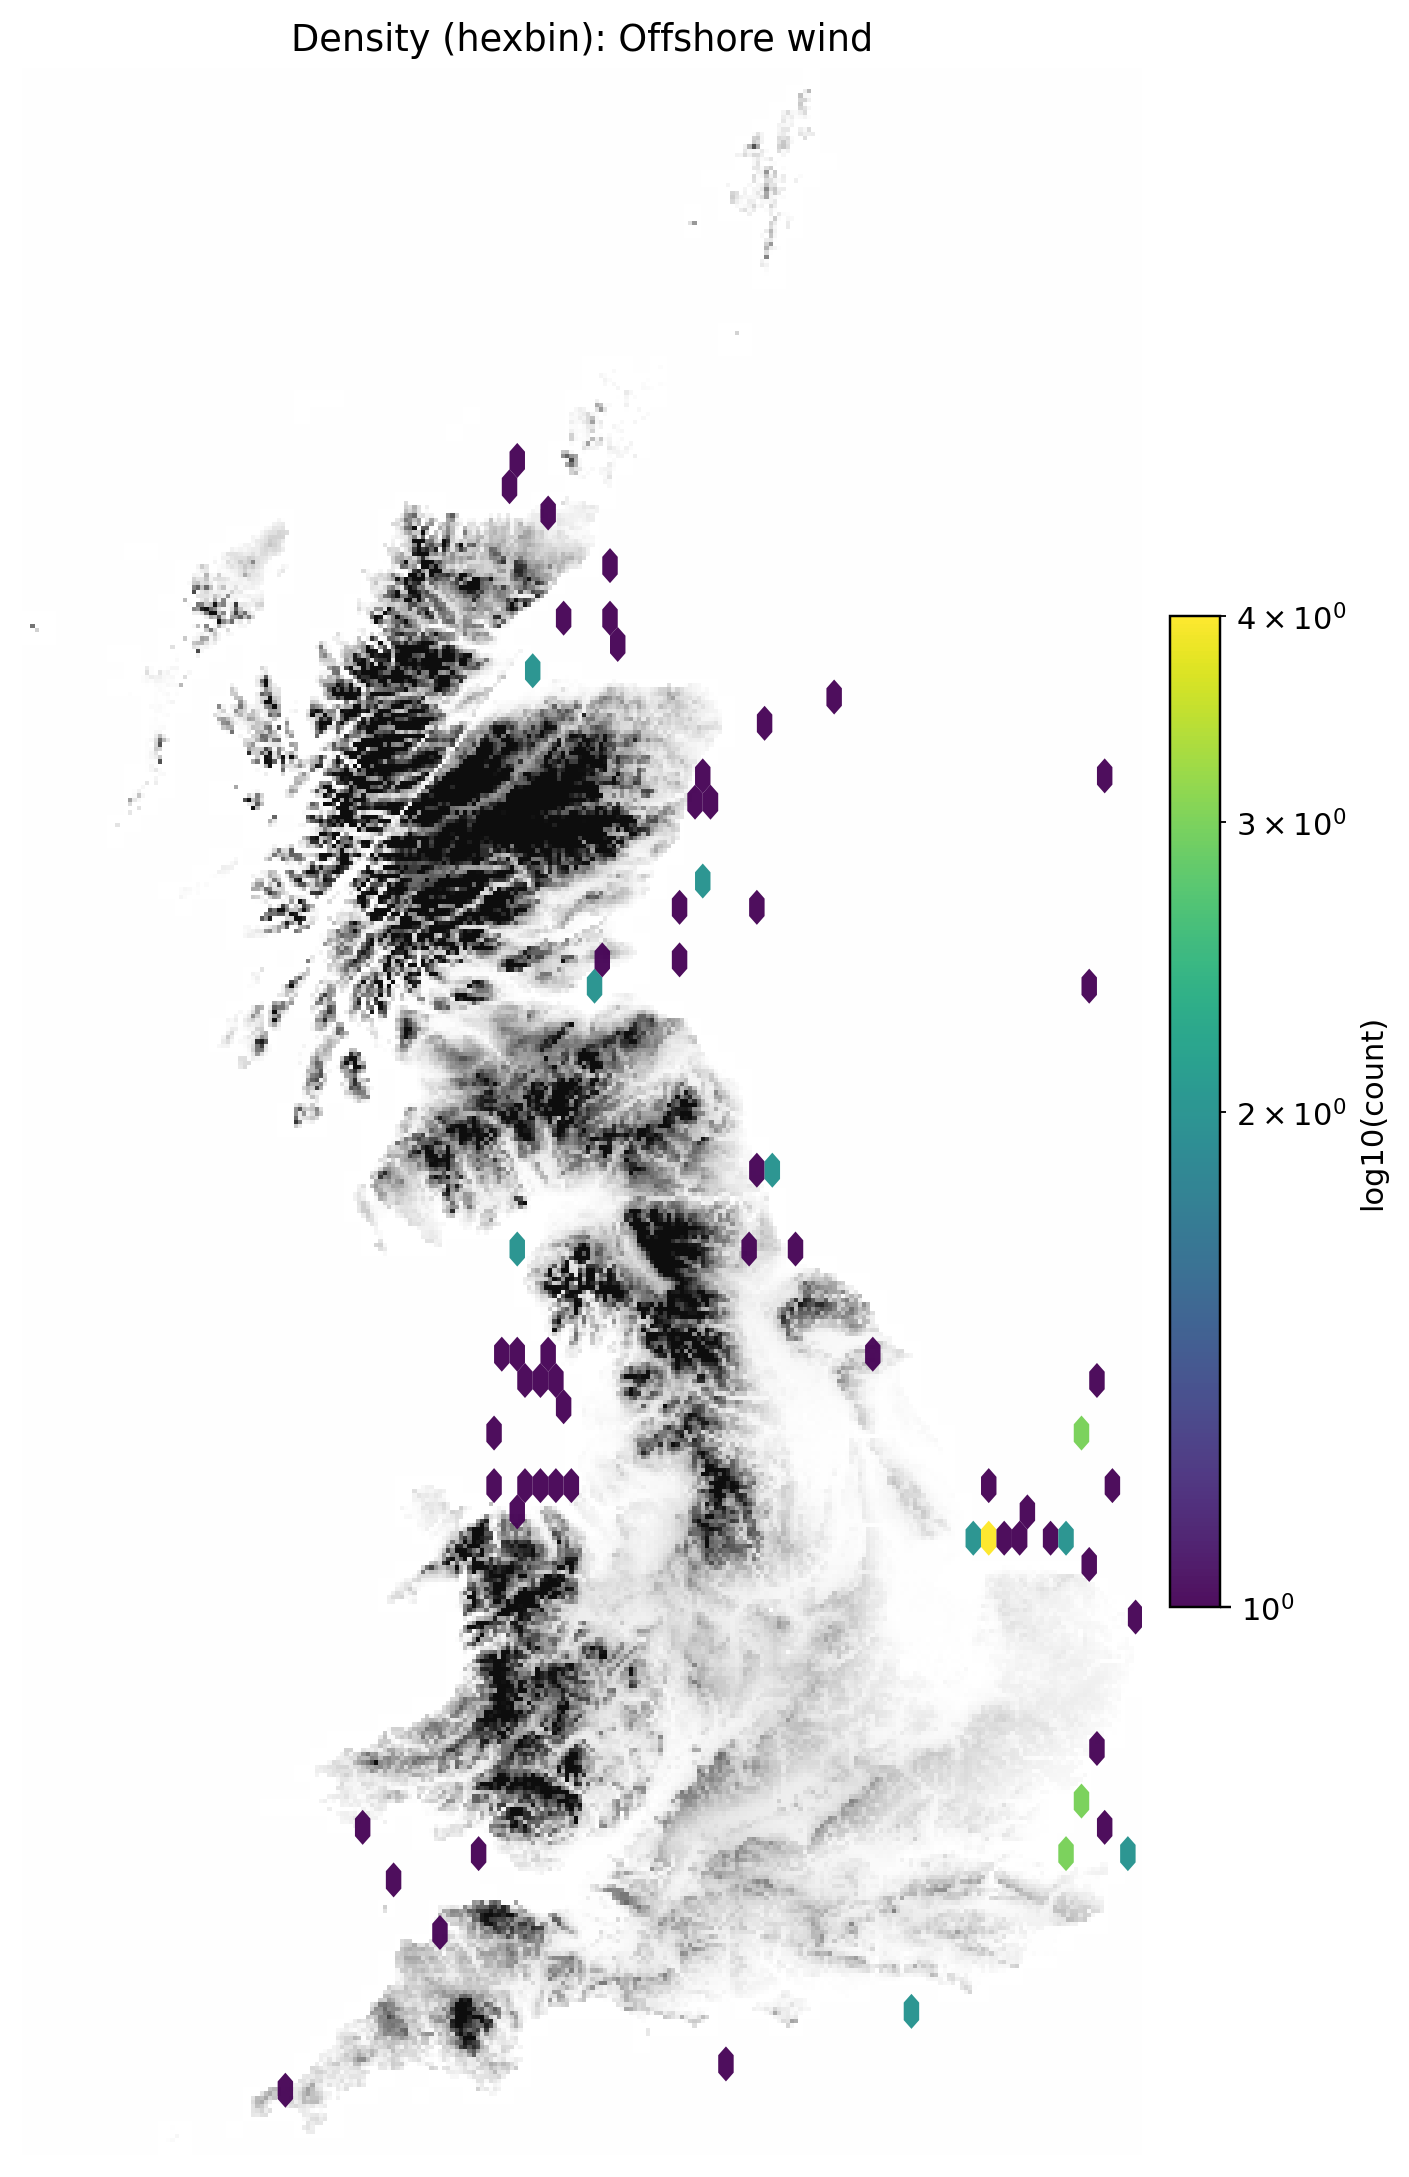

Saved: /Users/wangbobo/Desktop/hexbin_onshore.png
Saved: /Users/wangbobo/Desktop/hexbin_offshore.png


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent


terrain_dir = r"/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"
csv_dir     = r"/Users/wangbobo/Desktop/2nd_Assignment-20251222"   

tif_list = sorted(glob.glob(os.path.join(terrain_dir, "*.tif")))
if len(tif_list) == 0:
    raise FileNotFoundError(f"在 {terrain_dir} 没找到任何 .tif 文件，请确认 terrain 放在这个目录里")
terrain_path = tif_list[0]
print("Using terrain:", terrain_path)


csv_list = sorted(glob.glob(os.path.join(csv_dir, "*.csv")))
if len(csv_list) == 0:
    raise FileNotFoundError(f"在 {csv_dir} 没找到任何 .csv 文件，请确认你的CSV放在该目录里")
csv_path = csv_list[0]
print("Using CSV:", csv_path)

with rasterio.open(terrain_path) as src:
    terrain = src.read(1).astype("float32")
    extent = plotting_extent(src)  # (xmin, xmax, ymin, ymax)
    raster_crs = src.crs

terrain = np.where(np.isfinite(terrain), terrain, np.nan)
vmin = np.nanpercentile(terrain, 2)
vmax = np.nanpercentile(terrain, 98)


try:
    df = pd.read_csv(csv_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding="latin1")


xcol, ycol = "X-coordinate", "Y-coordinate"


if xcol not in df.columns or ycol not in df.columns:
    cols_lower = {c.lower(): c for c in df.columns}
    if "x-coordinate" in cols_lower and "y-coordinate" in cols_lower:
        xcol, ycol = cols_lower["x-coordinate"], cols_lower["y-coordinate"]
    elif "x" in cols_lower and "y" in cols_lower:
        xcol, ycol = cols_lower["x"], cols_lower["y"]
    else:
        raise KeyError(f"找不到坐标列。你现在CSV里的列名是：{list(df.columns)[:40]} ...")


tech_col_candidates = [
    "Technology Type", "Technology type", "Technology", "Technology Type (short)",
    "Technology Type (or similar)"
]
tech_col = None
for c in tech_col_candidates:
    if c in df.columns:
        tech_col = c
        break
if tech_col is None:
    
    for c in df.columns:
        if "tech" in c.lower() and "type" in c.lower():
            tech_col = c
            break
if tech_col is None:
    raise KeyError(f"找不到技术类型列（Technology Type）。CSV列名示例：{list(df.columns)[:40]} ...")


df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna(subset=[xcol, ycol])

df_wind = df[df[tech_col].astype(str).str.contains("Wind", case=False, na=False)].copy()
df_on   = df_wind[df_wind[tech_col].astype(str).str.contains("Onshore",  case=False, na=False)].copy()
df_off  = df_wind[df_wind[tech_col].astype(str).str.contains("Offshore", case=False, na=False)].copy()

print("Wind total:", len(df_wind), "| Onshore:", len(df_on), "| Offshore:", len(df_off))


xmin, xmax, ymin, ymax = extent

def clip_to_extent(d):
    return d[(d[xcol] >= xmin) & (d[xcol] <= xmax) & (d[ycol] >= ymin) & (d[ycol] <= ymax)].copy()

df_on  = clip_to_extent(df_on)
df_off = clip_to_extent(df_off)

print("After extent clip | Onshore:", len(df_on), "| Offshore:", len(df_off))


def plot_hexbin(ax, points_df, title, gridsize=55):
    ax.set_facecolor("white")

    ax.imshow(
        terrain,
        extent=extent,
        cmap="Greys",
        vmin=vmin,
        vmax=vmax,
        alpha=0.95,
        zorder=1
    )

    hb = ax.hexbin(
        points_df[xcol].values,
        points_df[ycol].values,
        gridsize=gridsize,
        mincnt=1,
        bins="log",          # log10(count)
        cmap="viridis",
        linewidths=0.0,
        alpha=0.95,
        zorder=2
    )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title, fontsize=12)
    return hb


fig1, ax1 = plt.subplots(figsize=(7.5, 10), dpi=220)
hb1 = plot_hexbin(ax1, df_on, "Density (hexbin): Onshore wind", gridsize=55)
cbar1 = plt.colorbar(hb1, ax=ax1, fraction=0.035, pad=0.02)
cbar1.set_label("log10(count)")
plt.tight_layout()

fig2, ax2 = plt.subplots(figsize=(7.5, 10), dpi=220)
hb2 = plot_hexbin(ax2, df_off, "Density (hexbin): Offshore wind", gridsize=55)
cbar2 = plt.colorbar(hb2, ax=ax2, fraction=0.035, pad=0.02)
cbar2.set_label("log10(count)")
plt.tight_layout()

plt.show()


out_on  = r"/Users/wangbobo/Desktop/hexbin_onshore.png"
out_off = r"/Users/wangbobo/Desktop/hexbin_offshore.png"

fig1.savefig(out_on, dpi=300, bbox_inches="tight", facecolor="white")
fig2.savefig(out_off, dpi=300, bbox_inches="tight", facecolor="white")

print("Saved:", out_on)
print("Saved:", out_off)
